Load và phân tích dữ liệu gốc

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from pathlib import Path

# --- Load dataset ---
data_path = Path("../../data_use/bbc_text_cls.csv")
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path.resolve()}. Check the relative path from this notebook (src/data_analysis).")
df = pd.read_csv(data_path)
print("Dataset loaded successfully!\n")
print(df.info())
print("\nSample rows:\n", df.sample(5))

Dataset loaded successfully!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None

Sample rows:
                                                    text         labels
2028  UK broadband gets speed injection\n\nBroadband...           tech
1407  Man Utd stroll to Cup win\n\nWayne Rooney made...          sport
1517  Yeading face Newcastle in FA Cup\n\nPremiershi...          sport
1180  Hague 'given up' his PM ambition\n\nFormer Con...       politics
721   Little Britain two top comic list\n\nLittle Br...  entertainment


In [15]:
# --- Quick sanity checks for dataset columns (inserted) ---
expected_cols = ['text','labels']
found_cols = list(df.columns)
print('Found columns (first 6):', found_cols[:6])
# Check names existence
missing = [c for c in expected_cols if c not in found_cols]
if missing:
    raise KeyError(f'Missing expected column(s): {missing} — check CSV header or encoding.')
# Check order of the first two columns
if found_cols[:len(expected_cols)] == expected_cols:
    print('Column names and order (first two) are correct.')
else:
    print(f"Warning: expected first columns {expected_cols} but found {found_cols[:len(expected_cols)]} — code will still work if names exist but order differs.")

Found columns (first 6): ['text', 'labels']
Column names and order (first two) are correct.


Kiểm tra missing values

In [16]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
text      0
labels    0
dtype: int64


Kiểm tra số lượng mẫu theo từng category

C:\Users\tranh\AppData\Local\Temp\ipykernel_5884\1291506858.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='labels', palette='viridis')


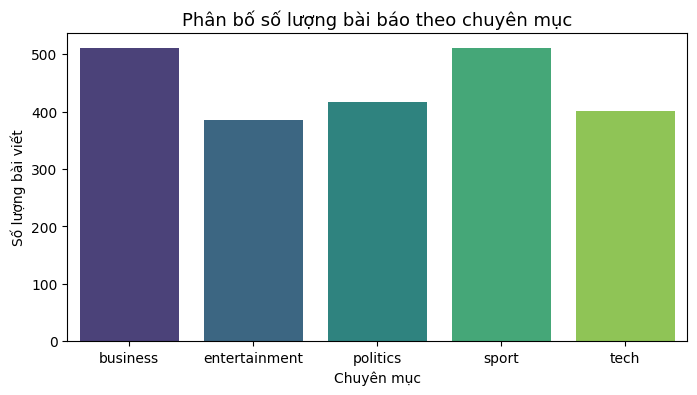

In [17]:

plt.figure(figsize=(8,4))
sns.countplot(data=df, x='labels', palette='viridis')
plt.title("Phân bố số lượng bài báo theo chuyên mục", fontsize=13)
plt.xlabel("Chuyên mục")
plt.ylabel("Số lượng bài viết")
plt.show()

Tính độ dài văn bản

C:\Users\tranh\AppData\Local\Temp\ipykernel_5884\119781162.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='labels', y='text_length', palette='Set2')


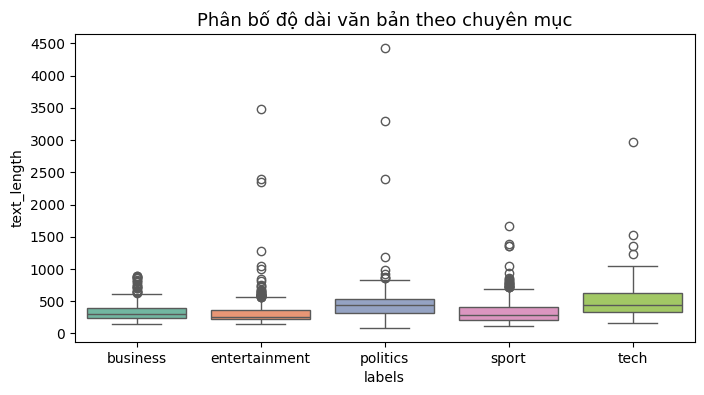


Thống kê độ dài văn bản:
               count        mean         std    min    25%    50%     75%  \
labels                                                                      
business       510.0  328.880392  135.919077  140.0  233.0  297.0  388.75   
entertainment  386.0  330.621762  261.795254  143.0  225.0  262.5  360.00   
politics       417.0  453.973621  300.120275   89.0  317.0  439.0  529.00   
sport          511.0  329.262231  187.963267  114.0  204.0  288.0  409.50   
tech           401.0  502.695761  239.849176  162.0  338.0  447.0  629.00   

                  max  
labels                 
business        891.0  
entertainment  3482.0  
politics       4432.0  
sport          1662.0  
tech           2969.0  


In [18]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='labels', y='text_length', palette='Set2')
plt.title("Phân bố độ dài văn bản theo chuyên mục", fontsize=13)
plt.yticks(range(0, int(df['text_length'].max()) + 500, 500))
plt.show()

print("\nThống kê độ dài văn bản:")
print(df.groupby('labels')['text_length'].describe())


Phân phối độ dài văn bản theo khoảng 500:
Độ dài (0, 500]: 1762 văn bản
Độ dài (500, 1000]: 439 văn bản
Độ dài (1000, 1500]: 15 văn bản
Độ dài (1500, 2000]: 2 văn bản
Độ dài (2000, 2500]: 3 văn bản
Độ dài (2500, 3000]: 1 văn bản
Độ dài (3000, 3500]: 2 văn bản
Độ dài (3500, 4000]: 0 văn bản
Độ dài (4000, 4500]: 1 văn bản


<Figure size 1500x600 with 0 Axes>

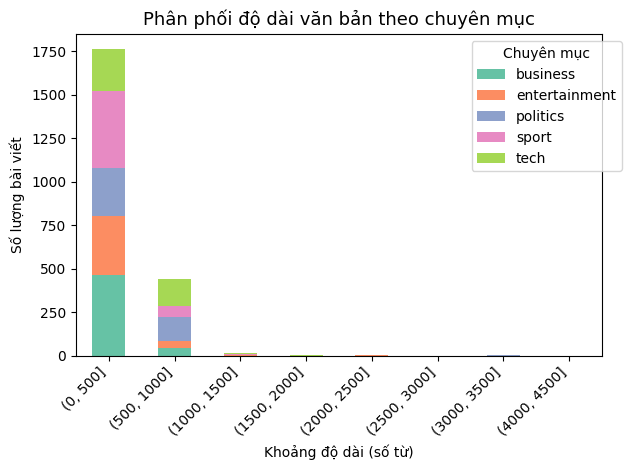


Phân phối theo % trong mỗi chuyên mục:
labels        business  entertainment  politics  sport   tech
length_range                                                 
(0, 500]         90.78          88.60     66.19  86.50  59.60
(500, 1000]       9.22          10.10     32.85  12.52  37.91
(1000, 1500]      0.00           0.52      0.24   0.78   2.00
(1500, 2000]      0.00           0.00      0.00   0.20   0.25
(2000, 2500]      0.00           0.52      0.24   0.00   0.00
(2500, 3000]      0.00           0.00      0.00   0.00   0.25
(3000, 3500]      0.00           0.26      0.24   0.00   0.00
(4000, 4500]      0.00           0.00      0.24   0.00   0.00


<Figure size 1500x600 with 0 Axes>

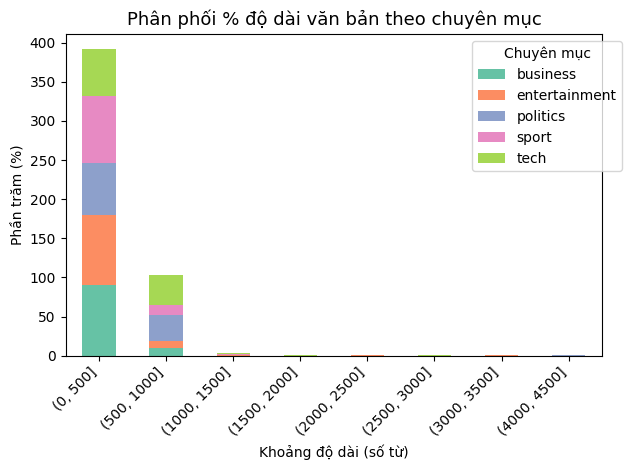

In [25]:
# Tạo bins với bước nhảy 500
bins = range(0, int(df['text_length'].max()) + 500, 500)
df['length_range'] = pd.cut(df['text_length'], bins=bins)

# Đếm số lượng văn bản trong mỗi khoảng
length_dist = df['length_range'].value_counts().sort_index()

print("\nPhân phối độ dài văn bản theo khoảng 500:")
for interval, count in length_dist.items():
    print(f"Độ dài {interval}: {count} văn bản")

# Tạo bảng phân phối theo length_range và labels
dist_by_category = pd.crosstab(df['length_range'], df['labels'])

# Vẽ stacked bar plot
plt.figure(figsize=(15, 6))
colors = sns.color_palette('Set2', n_colors=len(df['labels'].unique()))
dist_by_category.plot(kind='bar', stacked=True, color=colors)
plt.title("Phân phối độ dài văn bản theo chuyên mục", fontsize=13)
plt.xlabel("Khoảng độ dài (số từ)")
plt.ylabel("Số lượng bài viết")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Chuyên mục", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Thêm phần trăm cho mỗi category
print("\nPhân phối theo % trong mỗi chuyên mục:")
dist_by_category_pct = dist_by_category.apply(lambda x: x/x.sum() * 100, axis=0)
print(dist_by_category_pct.round(2))

# Vẽ 100% stacked bar plot
plt.figure(figsize=(15, 6))
dist_by_category_pct.plot(kind='bar', stacked=True, color=colors)
plt.title("Phân phối % độ dài văn bản theo chuyên mục", fontsize=13)
plt.xlabel("Khoảng độ dài (số từ)")
plt.ylabel("Phần trăm (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Chuyên mục", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Phân tích một vài bài viết

In [20]:
for cat in df['labels'].unique():
    sample_text = df[df['labels'] == cat].iloc[0]['text'][:300]
    print(f"\n--- {cat.upper()} ---\n{sample_text}\n")


--- BUSINESS ---
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and highe


--- ENTERTAINMENT ---
Gallery unveils interactive tree

A Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery.

The spruce has an antenna which can receive Bluetooth texts sent by visitors to the Tate. The messages will be "unwrapped" by sculptor Richard Wentworth, who is 


--- POLITICS ---
Labour plans maternity pay rise

Maternity pay for new mothers is to rise by £1,400 as part of new proposals announced by the Trade and Industry Secretary Patricia Hewitt.

It would mean paid leave would be increased to nine months by 2007, Ms Hewitt told GMTV's Sunday programme. Other plans include


--- SPORT ---
Claxton hunting firs

Token tần suất từ (thô, trước khi clean)

C:\Users\tranh\AppData\Local\Temp\ipykernel_5884\3457346419.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x='count', y='word', palette='coolwarm')


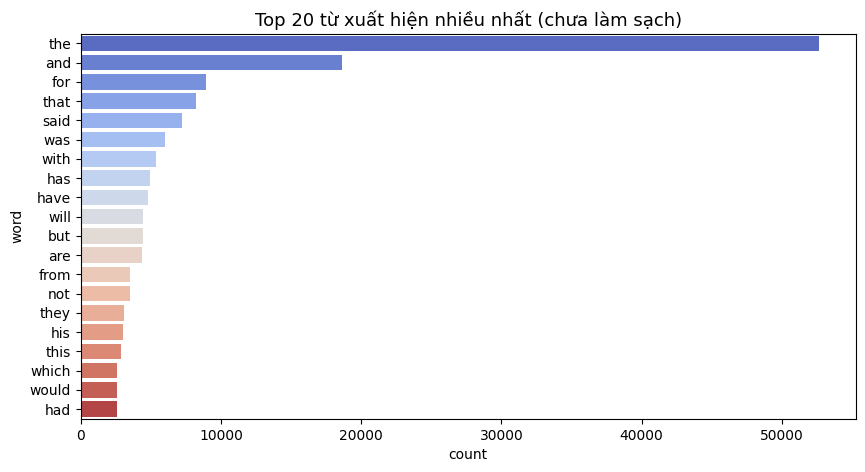

In [21]:

from collections import Counter

def get_top_words(texts, n=20):
    words = re.findall(r'\b[a-zA-Z]{3,}\b', " ".join(texts).lower())
    common = Counter(words).most_common(n)
    return pd.DataFrame(common, columns=['word', 'count'])

top_words = get_top_words(df['text'])
plt.figure(figsize=(10,5))
sns.barplot(data=top_words, x='count', y='word', palette='coolwarm')
plt.title("Top 20 từ xuất hiện nhiều nhất (chưa làm sạch)", fontsize=13)
plt.show()


WordCloud cho toàn bộ dataset

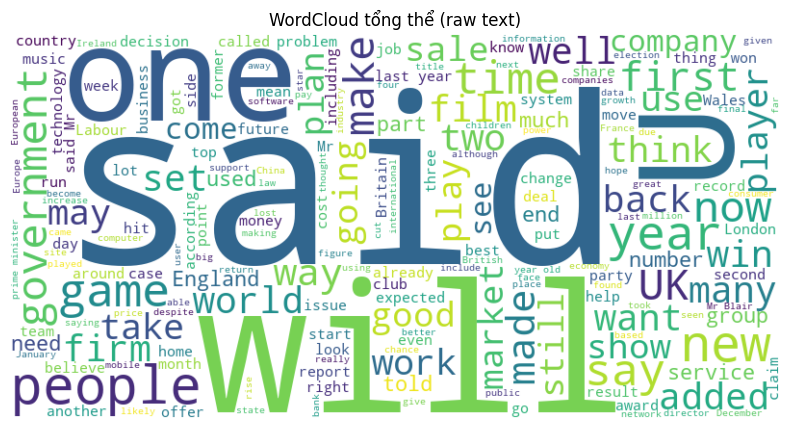

In [22]:


wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['text']))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud tổng thể (raw text)")
plt.show()

WordCloud cho từng chuyên mục

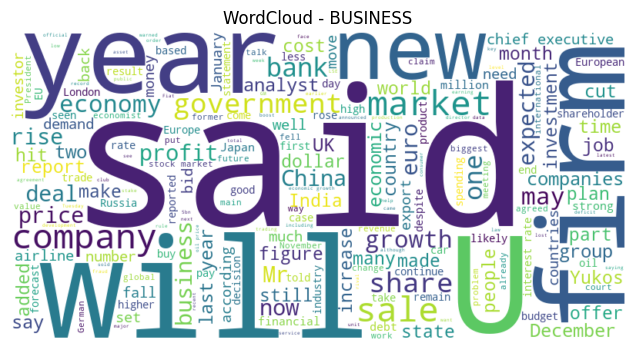

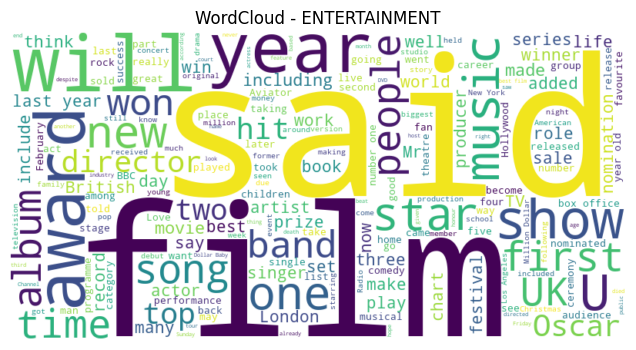

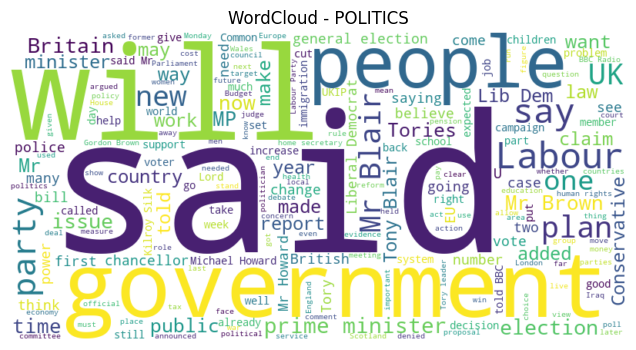

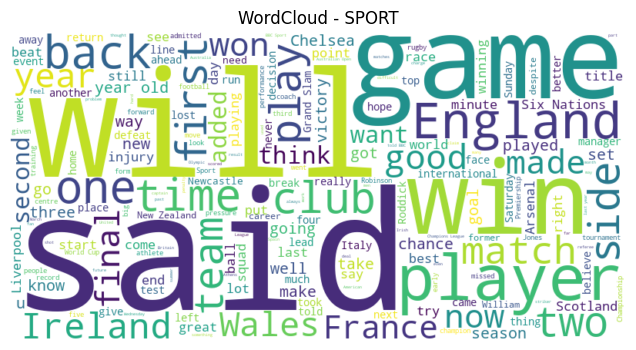

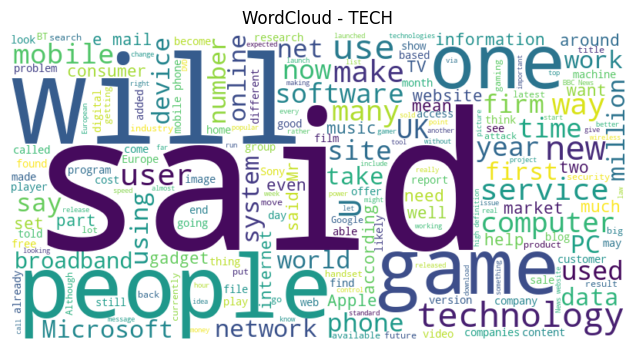

In [23]:

categories = df['labels'].unique()
for cat in categories:
    plt.figure(figsize=(8,4))
    text_cat = " ".join(df[df['labels'] == cat]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text_cat)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {cat.upper()}")
    plt.show()